In [1]:
import numpy as np

import os
import matplotlib.pyplot as plt
import struct

from my_turbgen import TurbGen

# Save Dir

In [2]:
save_dir = "./turbulent field"

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# Generate Turbulent Field

In [3]:
parameter_file = os.path.join(save_dir,"parameters.txt")

tg = TurbGen(parameter_file)

tg.init_single_realisation()
tg._set_pos_beg_end()
tg.get_turb_vector_unigrid()

# Shift and scale velocity field

In [4]:
v = tg.v

mean = np.mean(tg.v,axis=(1,2))
mean2 = np.mean(tg.v**2,axis=(1,2))

std = (mean2-mean*2)**.5
v = np.array([(_v-_mean)/_std for _v,_mean,_std in zip(v,mean,std)])
# v[-1][:] = 0

In [5]:
v.shape

(3, 64, 64, 64)

In [6]:
def shift_volume(toshift_idxes, *vals):
    """
    Redefines a volume of data to center a chosen point. It does this by cutting
        the data at a point determined by the desired center and glueing the opposite
        faces together, i.e. making use of the periodic spacial boundary conditions.

    Parameters
    ----------
    toshift_idxes : tuple
        Indices of the point which is to be moved to the center of the volume.
    *vals : np.ndarray
        Array of data which is to be shifted and glued.

    Returns
    -------
    vals_sh : np.ndarray
        Shifted values.
    """
    
    shape = vals[0].shape
    center_idxes = tuple(shp//2 for shp in shape)

    # Set up shifted values
    vals_sh = [val.copy() for val in vals]

    for i, (center_idx, toshift_idx) in enumerate(zip(center_idxes, toshift_idxes)):
        
        # Set up slices.
        slices_l = [slice(0,shp) for shp in shape]
        slices_r = [slice(0,shp) for shp in shape]
        
        shift = (toshift_idx-center_idx)%shape[i]
        slices_l[i] = slice(0,shift)
        slices_r[i] = slice(shift,None)
        
        # Change vals.
        for j, val_sh in enumerate(vals_sh):
            _val_sh_copy = val_sh.copy()
            vals_sh[j] = np.concatenate((_val_sh_copy,_val_sh_copy[tuple(slices_l)]),axis=i)
            vals_sh[j] = vals_sh[j][tuple(slices_r)]
            
    return vals_sh

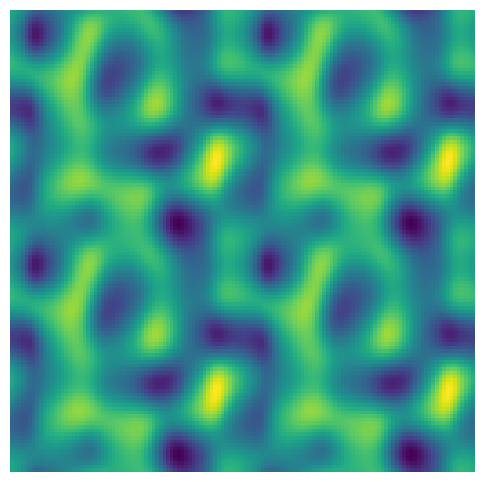

In [12]:
fig, axes = plt.subplots(2,2,figsize=(6,6),)

for ax in axes.flatten():
    ax.axis('off')
    # ax.set_aspect('equal')
    ax.pcolormesh(v[1][32])

fig.subplots_adjust(wspace=0, hspace=0)


In [23]:
from utils.differentiation_utils import gradient_discrete

dvx1 = gradient_discrete(v[0],tg.delt[:2])
dvx2 = gradient_discrete(v[1],tg.delt[:2])

div = dvx1[0]+dvx2[1]
curl = dvx2[0]-dvx1[1]

In [24]:
div[10::-10][10::-10].mean(), curl[10::-10][10::-10].mean()

(np.float64(-5.5330256515671605), np.float64(5.027517297131061))

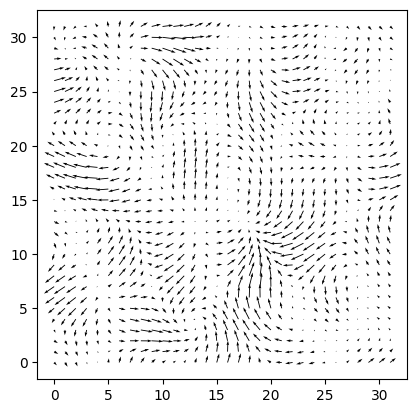

In [8]:
intv = 2
n_slice = 0

plt.quiver(v[0][::intv,::intv,0],v[1][::intv,::intv,0])

ax = plt.gca()
ax.set_aspect(1)

# Save turbulent velocities and associated grid0.out file for PLUTO

In [6]:
np.prod(tg.N), 64*64*64, v[0].shape

(262144, 262144, (64, 64, 64))

In [7]:
f_names = ["vx10.dbl", "vx20.dbl", "vx30.dbl"]
n_points = np.prod(tg.N)

for i,f_name in enumerate(f_names):
    with open(os.path.join(save_dir, f_name),'wb') as f_o:   
        f_o.write(struct.pack('<'+'d'*n_points,*((v[i]).flatten())))

with open(os.path.join(save_dir, "grid0.out"),'w') as f_out:
    f_out.write("# GEOMETRY:   CARTESIAN\n")
    for d in range(3):
        f_out.write(f"{tg.N[d]}\n")
        if tg.N[d]>1:
            for i in range(tg.N[d]):
                # xL = -tg.L[d]/2 + (tg.L[d]*(i))/(tg.N[d])
                # xR = -tg.L[d]/2 + (tg.L[d]*(i+1))/(tg.N[d])
                xL = -tg.L[d]/2 + (tg.L[d]*(i-.5))/(tg.N[d]-1)
                xR = -tg.L[d]/2 + (tg.L[d]*(i+.5))/(tg.N[d]-1)
                if i==0 or i==tg.N[d]-1:
                    print(xL,xR)
                f_out.write("{} {:.6f} {:.6f}\n".format(i+1,xL,xR))
        else:
            f_out.write("{} {:.6f} {:.6f}\n".format(1,0.0,1.0))

-0.5079365079365079 -0.4920634920634921
0.4920634920634921 0.5079365079365079
-0.5079365079365079 -0.4920634920634921
0.4920634920634921 0.5079365079365079
-0.5079365079365079 -0.4920634920634921
0.4920634920634921 0.5079365079365079


# Test

In [13]:
L = 1.
N = 128

K_MIN = 2
K_MAX = 3

k_min = 2*np.pi/L * K_MIN
k_max = 2*np.pi/L * K_MAX

k_min, k_max, 2*np.pi/k_min, 2*np.pi/k_max, L/N

(12.566370614359172, 18.84955592153876, 0.5, 0.3333333333333333, 0.0078125)

In [65]:
k_min = 2*np.pi/tg.L[0] * tg.K_MIN
k_max = 2*np.pi/tg.L[0] * tg.K_MAX

l_max = 2*np.pi/k_min
l_min = 2*np.pi/k_max

In [67]:
l_max, l_min

(0.5, 0.3333333333333333)

In [21]:
from Kea.Kea.statistics.spectra.spectra_base import calculate_integrated_spectrum

In [22]:
out = calculate_integrated_spectrum([np.sum([_v**2 for _v in v],axis=0)**.5])

/home/yangelaxue/clusters/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [23]:
k = out[0]
f1 = out[1]
# f2 = out[2]
# f3 = out[3]
ftrace = out[-1]

In [25]:
import powerbox as pbox

In [27]:
v.shape

(2, 256, 256)

In [30]:
p_k_field, bins_field = pbox.get_power((v[0]**2+v[1]**2)**.5, 1)

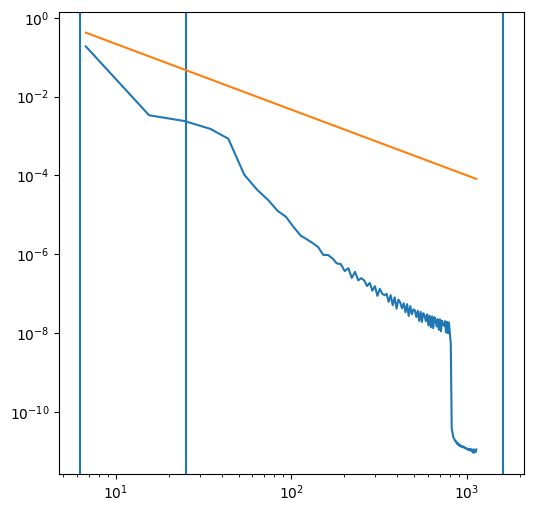

In [32]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(bins_field,p_k_field)
# ax.plot(k,f2)
# ax.plot(k,f3)
# ax.plot(k,ftrace)

ax.axvline(tg.K_MIN * 2*np.pi/tg.L[0])
ax.axvline(tg.K_MAX * 2*np.pi/tg.L[0])
ax.axvline(2*np.pi/tg.delt[0])
# ax.axvline(2*np.pi/dx)
ax.plot(bins_field,bins_field**(-5/3)*10)

ax.set_yscale('log')
ax.set_xscale('log')

In [5]:
"""
Drive turbulence.
"""

tg._set_turnover_time()
v_t = tg.evolve_turb_grid(tg.t_decay,[i for i in range(3)])